# Case Study 1: Computational Methods in Finance

## Charles Laferte - cl4249

# Introduction

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy.stats import norm
import scipy

### Parameters:

In [87]:
S0 = 1900 # spot price
T = 0.25 # maturity
sigma = 0.36 # volatility
r = 0.02 # risk-free interest rate 
q = 0.0187 # continuous dividend rate

Let's compute the different true values of the call prices we will work on during the study case using the closed form from BMS.

In [90]:
# Function to compute the closed form value of the call

def BMS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Merton Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BMS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Merton Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BMS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Merton Scholes price for a 'call' or 'put' option '''
    tau = T - t
    d1 = BMS_d1(S, K, r, q, sigma, tau)
    d2 = BMS_d2(S, K, r, q, sigma, tau)
    if type_option == 'call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price

print('Call price for K = 2000 : ',BMS_price('call', S0, 2000, r, q, sigma, T, t=0))
print('Call price for K = 2100 : ',BMS_price('call', S0, 2100, r, q, sigma, T, t=0))
print('Call price for K = 2200 : ',BMS_price('call', S0, 2200, r, q, sigma, T, t=0))

Call price for K = 2000 :  95.2466924265716
Call price for K = 2100 :  64.83462030513067
Call price for K = 2200 :  42.94717532152765


### Case study stucture:
1. Fast Fourier transfrom (FFT)
    1. Strike K = 2000 (FFT)
    2. Strike K = 2100 (FFT)
    3. Strike K = 2100 (FFT)
2. Fractional fast Fourier transform (FrFFT) 
    1. Strike K = 2000 (FrFFT)
    2. Strike K = 2100 (FrFFT)
    3. Strike K = 2100 (FrFFT)
    
3. Fourier-cosine (COS)
    1. Function for the fourier-cosine method 
    2. Computations for the sensivity analysis
    3. Sensivity analysis results


# 1. Fast Fourier transfrom (FFT)

We will consider η = ∆ν = 0.25, α = 0.4,1.0,1.4,3.0, N = 2n for n = 9,11,13,15, and
β = ln(K) −λN/2

In [91]:
# Real charasteristic function
def phi(S0,r,q,sigma,T,u):
    phi = np.exp(1j*(np.log(S0)+(r-q-0.5*sigma**2)*T)*u-0.5*sigma**2*u**2*T)
    return phi

def call_pricing_FFT(alpha, delta_nu, n, r, q, T, eta, S0, K): 
    
    # Param
    N =2**n
    lambda_ = 2*np.pi/(N*eta)
    beta = np.log(K)-N*lambda_/2
    
    
    # X
    X = np.zeros(N)
    df = np.exp(-r*T)
    for i in range(N):
        nu = (i)*eta
        a = phi(S0, r, q, sigma, T,nu+complex(0,-alpha-1))
        b = (alpha+1j*nu)*(alpha+1j*nu+1)
        X[i] = eta*df*np.exp(-1j*beta*nu)*a/b
        
    X[0]=X[0]/2# first line adjustment

    
    # fft(x) = Y
    Y  = np.fft.fft(X)
    
    # Strike km for m = 1, ... ,N
    strikes = np.array([beta+m*lambda_ for m in range(N)])

    # Call prices
    C = np.array([np.exp(-alpha*k)/np.pi for k in strikes])*np.real(Y)
    
    data = pd.DataFrame({"Strike": np.exp(strikes),"Option Premium":C})
    print("Option via FFT: For Strike Price %s, the Option Premium is: " %K)
    print(str(round(data.iloc[int(0.5*N)]["Option Premium"],4)))
    
    price = round(data.iloc[int(0.5*N)]["Option Premium"],4)
    return price, strikes, C

## 1.1 Strike K = 2000 (FFT)

In [13]:
eta = 0.25
delta_nu = 0.25
S0=1900
K= 2000

n_l = [9,11, 13, 15]
alpha_l = [0.4,1, 1.4, 3]

L=[]
for alpha in alpha_l:
    l=[]
    for n in n_l:
        start_time = time.time()
        price, strikes, C = call_pricing_FFT(alpha, delta_nu, n, r, q, T, eta, S0, K)
        duration = time.time()-start_time
        print("Computation duration: ", duration)
        print(price,alpha, n)
        l.append(price)
        
        print(80*'=')
    L.append(l)
#plt.plot(strikes, C)
#plt.title('Call option price depending on the strike (log scale)')
#plt.show()
#print(L)
D = np.array(L).T


df_result_FFT = pd.DataFrame({'alpha':alpha_l})

for i in range(len(D)):
    df_result_FFT['N=2**'+str(n_l[i])] = D[i]



Option via FFT: For Strike Price 2000, the Option Premium is: 
95.3281
Computation duration:  0.08600306510925293
95.3281 0.4 9
Option via FFT: For Strike Price 2000, the Option Premium is: 
95.3281
Computation duration:  0.024889230728149414
95.3281 0.4 11
Option via FFT: For Strike Price 2000, the Option Premium is: 
95.3281
Computation duration:  0.08210086822509766
95.3281 0.4 13
Option via FFT: For Strike Price 2000, the Option Premium is: 
95.3281
Computation duration:  0.34630608558654785
95.3281 0.4 15
Option via FFT: For Strike Price 2000, the Option Premium is: 
95.2467
Computation duration:  0.0063152313232421875
95.2467 1 9
Option via FFT: For Strike Price 2000, the Option Premium is: 
95.2467
Computation duration:  0.02151179313659668
95.2467 1 11
Option via FFT: For Strike Price 2000, the Option Premium is: 
95.2467
Computation duration:  0.0818929672241211
95.2467 1 13
Option via FFT: For Strike Price 2000, the Option Premium is: 
95.2467
Computation duration:  0.3463277

In [14]:
print(f'Strike = {K}')
df_result_FFT

Strike = 2000


,alpha,N=2**9,N=2**11,N=2**13,N=2**15
0,0.4,95.3281,95.3281,95.3281,95.3281
1,1.0,95.2467,95.2467,95.2467,95.2467
2,1.4,95.2467,95.2467,95.2467,95.2467
3,3.0,95.2467,95.2467,95.2467,95.2467


## 1.2 Strike K  = 2100 (FFT)

In [16]:
eta = 0.25
delta_nu = 0.25
S0=1900
K= 2100

n_l = [9,11, 13, 15]
alpha_l = [0.4,1, 1.4, 3]

L=[]
for alpha in alpha_l:
    l=[]
    for n in n_l:
        start_time = time.time()
        price, strikes, C = call_pricing_FFT(alpha, delta_nu, n, r, q, T, eta, S0, K)
        duration = time.time()-start_time
        print("Computation duration: ", duration)
        print(price,alpha, n)
        l.append(price)
        
        print(80*'=')
    L.append(l)
#plt.plot(strikes, C)
#plt.title('Call option price depending on the strike (log scale)')
#plt.show()
#print(L)
D = np.array(L).T


df_result_FFT = pd.DataFrame({'alpha':alpha_l})

for i in range(len(D)):
    df_result_FFT['N=2**'+str(n_l[i])] = D[i]

Option via FFT: For Strike Price 2100, the Option Premium is: 
64.916
Computation duration:  0.014955759048461914
64.916 0.4 9
Option via FFT: For Strike Price 2100, the Option Premium is: 
64.916
Computation duration:  0.07114791870117188
64.916 0.4 11
Option via FFT: For Strike Price 2100, the Option Premium is: 
64.916
Computation duration:  0.8570036888122559
64.916 0.4 13
Option via FFT: For Strike Price 2100, the Option Premium is: 
64.916
Computation duration:  2.8778128623962402
64.916 0.4 15
Option via FFT: For Strike Price 2100, the Option Premium is: 
64.8346
Computation duration:  0.021813154220581055
64.8346 1 9
Option via FFT: For Strike Price 2100, the Option Premium is: 
64.8346
Computation duration:  0.36940479278564453
64.8346 1 11
Option via FFT: For Strike Price 2100, the Option Premium is: 
64.8346
Computation duration:  1.0459938049316406
64.8346 1 13
Option via FFT: For Strike Price 2100, the Option Premium is: 
64.8346
Computation duration:  1.1787090301513672
6

In [17]:
print(f'Strike = {K}')
df_result_FFT

Strike = 2100


,alpha,N=2**9,N=2**11,N=2**13,N=2**15
0,0.4,64.9160,64.9160,64.9160,64.9160
1,1.0,64.8346,64.8346,64.8346,64.8346
2,1.4,64.8346,64.8346,64.8346,64.8346
3,3.0,64.8346,64.8346,64.8346,64.8346


## 1.3 Strike K = 2200 (FFT)

In [18]:
eta = 0.25
delta_nu = 0.25
S0=1900
K= 2200

n_l = [9,11, 13, 15]
alpha_l = [0.4,1, 1.4, 3]

L=[]
for alpha in alpha_l:
    l=[]
    for n in n_l:
        start_time = time.time()
        price, strikes, C = call_pricing_FFT(alpha, delta_nu, n, r, q, T, eta, S0, K)
        duration = time.time()-start_time
        print("Computation duration: ", duration)
        print(price,alpha, n)
        l.append(price)
        
        print(80*'=')
    L.append(l)
#plt.plot(strikes, C)
#plt.title('Call option price depending on the strike (log scale)')
#plt.show()
#print(L)
D = np.array(L).T


df_result_FFT = pd.DataFrame({'alpha':alpha_l})

for i in range(len(D)):
    df_result_FFT['N=2**'+str(n_l[i])] = D[i]

Option via FFT: For Strike Price 2200, the Option Premium is: 
43.0286
Computation duration:  0.021656036376953125
43.0286 0.4 9
Option via FFT: For Strike Price 2200, the Option Premium is: 
43.0286
Computation duration:  0.07323908805847168
43.0286 0.4 11
Option via FFT: For Strike Price 2200, the Option Premium is: 
43.0286
Computation duration:  0.10764789581298828
43.0286 0.4 13
Option via FFT: For Strike Price 2200, the Option Premium is: 
43.0286
Computation duration:  0.35135602951049805
43.0286 0.4 15
Option via FFT: For Strike Price 2200, the Option Premium is: 
42.9472
Computation duration:  0.005632162094116211
42.9472 1 9
Option via FFT: For Strike Price 2200, the Option Premium is: 
42.9472
Computation duration:  0.02191472053527832
42.9472 1 11
Option via FFT: For Strike Price 2200, the Option Premium is: 
42.9472
Computation duration:  0.08111119270324707
42.9472 1 13
Option via FFT: For Strike Price 2200, the Option Premium is: 
42.9472
Computation duration:  0.4599750

In [19]:
print(f'Strike = {K}')
df_result_FFT

Strike = 2200


,alpha,N=2**9,N=2**11,N=2**13,N=2**15
0,0.4,43.0286,43.0286,43.0286,43.0286
1,1.0,42.9472,42.9472,42.9472,42.9472
2,1.4,42.9472,42.9472,42.9472,42.9472
3,3.0,42.9472,42.9472,42.9472,42.9472


# 2. Fractional fast Fourier transform (FrFFT)

We will consider η = ∆ν = 0.25, λ = ∆k = 0.1, α = 0.4,1.0,1.4,3.0, N = 2n for
n = 6,7,8,9, and β = ln(K)−λN/2.

In [130]:
# Real charasteristic function
def phi(S0,r,q,sigma,T,u):
    phi = np.exp(1j*(np.log(S0)+(r-q-0.5*sigma**2)*T)*u-0.5*sigma**2*u**2*T)
    return phi

def call_pricing_FrFFT(alpha, delta_nu, n, r, q, T, eta, S0, K,lambda_): 
    
    # Param
    N = 2**n
    beta = np.log(K)-N*lambda_/2
    gamma = eta*lambda_/(2*np.pi)
    
    # Form X
    X = np.zeros(N)
    C = np.exp(-r*T)
    for i in range(N):
        nu = (i)*eta
        a = phi(S0, r, q, sigma, T,nu+complex(0,-alpha-1))
        b = (alpha+1j*nu)*(alpha+1j*nu+1)
        X[i] = eta*C*np.exp(-1j*beta*nu)*a/b
        
    X[0]=X[0]/2# first line adjustment
    
    # Form Y 
    Y  = np.array([np.exp(-1j*np.pi*gamma*i**2)*X[i] for i in range(N)]+[0]*N)
    Y_hat = np.fft.fft(Y)
    
    # Form Z
    Z = [np.exp(1j*np.pi*gamma*i**2) for i in range(N)]
    Z = np.array(Z+list(reversed(Z)))
    Z_hat = np.fft.fft(Z)
    
    # Compute ksi
    ksi = np.fft.ifft(Y_hat*Z_hat)
    
    # Strike km for m = 1, ... ,N
    strikes = np.array([beta+m*lambda_ for m in range(N)])
    
    # Call prices
    C = np.array([np.real(ksi[k]*np.exp(-1j*np.pi*gamma*k**2)) * np.exp(-alpha*strikes[k])/np.pi for k in range(N)])
    
    data = pd.DataFrame({"Strike": np.exp(strikes),"Option Premium":C})
    print("Option via FrFFT: For Strike Price K = %s, the Option Premium is: " %K)
    print(str(round(data.iloc[int(0.5*N)]["Option Premium"],4)))
    
    price = round(data.iloc[int(0.5*N)]["Option Premium"],4)
    
    return price, strikes, C

## 2.1 Strike K = 2000 (FrFFT)

In [11]:
eta = 0.25
delta_nu = 0.25
S0=1900
K= 2000
lambda_ =0.1

n_l = [6,7,8,9]
alpha_l = [0.4,1, 1.4, 3]

L=[]
for alpha in alpha_l:
    l=[]
    for n in n_l:
        start_time = time.time()
        price, strikes, C = call_pricing_FrFFT(alpha, delta_nu, n, r, q, T, eta, S0, K, lambda_)
        duration = time.time()-start_time
        print("Computation duration: ", duration)
        print(price,alpha, n)
        l.append(price)
        
        print(80*'=')
    L.append(l)
#plt.plot(strikes, C)
#plt.title('Call option price depending on the strike (log scale)')
#plt.show()
#print(L)
D = np.array(L).T


df_result_FrFFT = pd.DataFrame({'alpha':alpha_l})

for i in range(len(D)):
    df_result_FrFFT['N=2**'+str(n_l[i])] = D[i]

Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
120.773
Computation duration:  0.004251241683959961
120.773 0.4 6
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
53.3165
Computation duration:  0.004575014114379883
53.3165 0.4 7
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
315.1885
Computation duration:  0.009269952774047852
315.1885 0.4 8
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
429.4228
Computation duration:  0.05272793769836426
429.4228 0.4 9
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
49.1717
Computation duration:  0.004532337188720703
49.1717 1 6
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
47.626
Computation duration:  0.012305021286010742
47.626 1 7
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
249.7166
Computation duration:  0.012658119201660156
249.7166 1 8
Option via FrFFT: For Strike Price K = 2000, the Option Pr

In [12]:
print(f'Strike = {K}')
df_result_FrFFT

Strike = 2000


,alpha,N=2**6,N=2**7,N=2**8,N=2**9
0,0.4,120.7730,53.3165,315.1885,429.4228
1,1.0,49.1717,47.6260,249.7166,265.5165
2,1.4,47.6224,47.6225,215.2645,197.5578
3,3.0,47.1893,47.6199,127.0006,81.2383


## 2.2 Strike K = 2100 (FrFFT)

In [9]:
eta = 0.25
delta_nu = 0.25
S0=1900
K= 2100
lambda_ =0.1

n_l = [6,7,8,9]
alpha_l = [0.4,1, 1.4, 3]

L=[]
for alpha in alpha_l:
    l=[]
    for n in n_l:
        start_time = time.time()
        price, strikes, C = call_pricing_FrFFT(alpha, delta_nu, n, r, q, T, eta, S0, K, lambda_)
        duration = time.time()-start_time
        print("Computation duration: ", duration)
        print(price,alpha, n)
        l.append(price)
        
        print(80*'=')
    L.append(l)
#plt.plot(strikes, C)
#plt.title('Call option price depending on the strike (log scale)')
#plt.show()
#print(L)
D = np.array(L).T


df_result_FrFFT = pd.DataFrame({'alpha':alpha_l})

for i in range(len(D)):
    df_result_FrFFT['N=2**'+str(n_l[i])] = D[i]

Option via FrFFT: For Strike Price K = 2100, the Option Premium is: 
105.7646
Computation duration:  0.0029540061950683594
105.7646 0.4 6
Option via FrFFT: For Strike Price K = 2100, the Option Premium is: 
38.1122
Computation duration:  0.005702972412109375
38.1122 0.4 7
Option via FrFFT: For Strike Price K = 2100, the Option Premium is: 
274.6038
Computation duration:  0.014868974685668945
274.6038 0.4 8
Option via FrFFT: For Strike Price K = 2100, the Option Premium is: 
400.7706
Computation duration:  0.02225208282470703
400.7706 0.4 9
Option via FrFFT: For Strike Price K = 2100, the Option Premium is: 
34.2007
Computation duration:  0.005454063415527344
34.2007 1 6
Option via FrFFT: For Strike Price K = 2100, the Option Premium is: 
32.4225
Computation duration:  0.006888866424560547
32.4225 1 7
Option via FrFFT: For Strike Price K = 2100, the Option Premium is: 
215.3367
Computation duration:  0.010272979736328125
215.3367 1 8
Option via FrFFT: For Strike Price K = 2100, the Opti

In [10]:
print(f'Strike = {K}')
df_result_FrFFT

Strike = 2100


,alpha,N=2**6,N=2**7,N=2**8,N=2**9
0,0.4,105.7646,38.1122,274.6038,400.7706
1,1.0,34.2007,32.4225,215.3367,242.6354
2,1.4,32.6630,32.4192,184.1533,177.0704
3,3.0,32.2015,32.4159,104.2635,64.8482


## 2.3 Strike K = 2200 (FrFFT)

In [8]:
eta = 0.25
delta_nu = 0.25
S0=1900
K= 2200
lambda_ =0.1

n_l = [6,7,8,9]
alpha_l = [0.4,1, 1.4, 3]

L=[]
for alpha in alpha_l:
    l=[]
    for n in n_l:
        start_time = time.time()
        price, strikes, C = call_pricing_FrFFT(alpha, delta_nu, n, r, q, T, eta, S0, K, lambda_)
        duration = time.time()-start_time
        print("Computation duration: ", duration)
        print(price,alpha, n)
        l.append(price)
        
        print(80*'=')
    L.append(l)
#plt.plot(strikes, C)
#plt.title('Call option price depending on the strike (log scale)')
#plt.show()
#print(L)
D = np.array(L).T


df_result_FrFFT = pd.DataFrame({'alpha':alpha_l})

for i in range(len(D)):
    df_result_FrFFT['N=2**'+str(n_l[i])] = D[i]

Option via FrFFT: For Strike Price K = 2200, the Option Premium is: 
94.8983
Computation duration:  0.0034737586975097656
94.8983 0.4 6
Option via FrFFT: For Strike Price K = 2200, the Option Premium is: 
27.1678
Computation duration:  0.005434989929199219
27.1678 0.4 7
Option via FrFFT: For Strike Price K = 2200, the Option Premium is: 
238.6922
Computation duration:  0.013274669647216797
238.6922 0.4 8
Option via FrFFT: For Strike Price K = 2200, the Option Premium is: 
376.3807
Computation duration:  0.017858028411865234
376.3807 0.4 9
Option via FrFFT: For Strike Price K = 2200, the Option Premium is: 
23.3896
Computation duration:  0.011293888092041016
23.3896 1 6
Option via FrFFT: For Strike Price K = 2200, the Option Premium is: 
21.4791
Computation duration:  0.022025108337402344
21.4791 1 7
Option via FrFFT: For Strike Price K = 2200, the Option Premium is: 
185.5293
Computation duration:  0.013445854187011719
185.5293 1 8
Option via FrFFT: For Strike Price K = 2200, the Optio

In [7]:
print(f'Strike = {K}')
df_result_FrFFT

Strike = 2100


,alpha,N=2**6,N=2**7,N=2**8,N=2**9
0,0.4,105.7646,38.1122,274.6038,400.7706
1,1.0,34.2007,32.4225,215.3367,242.6354
2,1.4,32.6630,32.4192,184.1533,177.0704
3,3.0,32.2015,32.4159,104.2635,64.8482


## 2.4 Observations: 

We can observe the method struggles to compute the correct values for the call prices. It seems it depends on the lambda value we choose. Here, lambda is 0.1. However, if we try to compute the call price for K=2000 but with lambda smaller, the method perfoms well.

In [147]:
eta = 0.25
delta_nu = 0.25
S0=1900
K= 2000
lambda_ = 0.0000000001

n_l = [6,7,8,9]
alpha_l = [0.4,1, 1.4, 3]

L=[]
for alpha in alpha_l:
    l=[]
    for n in n_l:
        start_time = time.time()
        price, strikes, C = call_pricing_FrFFT(alpha, delta_nu, n, r, q, T, eta, S0, K, lambda_)
        duration = time.time()-start_time
        print("Computation duration: ", duration)
        print(price,alpha, n)
        l.append(price)
        
        print(80*'=')
    L.append(l)
#plt.plot(strikes, C)
#plt.title('Call option price depending on the strike (log scale)')
#plt.show()
#print(L)
D = np.array(L).T


df_result_FrFFT = pd.DataFrame({'alpha':alpha_l})

for i in range(len(D)):
    df_result_FrFFT['N=2**'+str(n_l[i])] = D[i]

Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
95.3845
Computation duration:  0.004909992218017578
95.3845 0.4 6
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
95.3281
Computation duration:  0.0047910213470458984
95.3281 0.4 7
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
95.3281
Computation duration:  0.01753091812133789
95.3281 0.4 8
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
95.3281
Computation duration:  0.026861906051635742
95.3281 0.4 9
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
95.3041
Computation duration:  0.008012771606445312
95.3041 1 6
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
95.2467
Computation duration:  0.006082057952880859
95.2467 1 7
Option via FrFFT: For Strike Price K = 2000, the Option Premium is: 
95.2467
Computation duration:  0.015872955322265625
95.2467 1 8
Option via FrFFT: For Strike Price K = 2000, the Option Premi

In [148]:
print(f'Strike = {K}')
df_result_FrFFT

Strike = 2000


,alpha,N=2**6,N=2**7,N=2**8,N=2**9
0,0.4,95.3845,95.3281,95.3281,95.3281
1,1.0,95.3041,95.2467,95.2467,95.2467
2,1.4,95.2998,95.2467,95.2467,95.2467
3,3.0,95.2520,95.2467,95.2467,95.2467


We know that the stepsize lambda can introduce some interpolation error. We can also note that for FFT, we used lambda taking values between 0.049 and 0.00076 (even if we did not choose directly lambda value). 

### Note: 

In [151]:
lbda = 0.1
money_ness = 2**6*lbda/2
money_ness

3.2

Here, we see that choosing lambda around 0.1 corresponds to very large money-ness which might explain some bizarre results.


In [152]:
lbda = 0.0001
money_ness = 2**9*lbda/2
money_ness

0.0256

# 3. Fourier-cosine (COS) 

We will consider values [−1,1], [−4,4], [−8,8], [−12,12] for the interval [a,b] and find the
sensitivity of your results to the choice of [a,b]

In [92]:
K = 2000

In [100]:
import mpmath as mp

In [158]:
r

0.02

## 3.1 Function for the fourier-cosine method

In [161]:
# Real charasteristic function
def phi(S0,r,q,sigma,T,u):
    phi = np.exp(1j*(np.log(S0) + (r-q-0.5*sigma**2)*T)*u-0.5*sigma**2*u**2*T)
    return phi


# Approximated charasteristic function
def phi_hat(S0,r,q,sigma,T,u, a,b):
    def integ(x):
        inte = np.exp(1j*u*x-0.5*((x-np.log(S0)-(r-q-sigma**2/2)*T)/(sigma*np.sqrt(T)))**2)/(sigma*np.sqrt(2*np.pi*T)) 
        return (inte)
    #print('integrate')
    #print(integrate.quad(integ, a,b))
    phi_real = integrate.quad(integ, a,b)[0]
    phi_imag = integrate.quad(lambda x: scipy.imag(integ(x)), a,b)[0]
    # print(phi)
    #
    phi = phi_real + 1j*phi_imag
    return phi


def cos(a, b, S0, sigma, T, r, q, K, n):
    
    N = 2**n
    A,V = np.zeros(N), np.zeros(N)
    C = np.exp(-r*T)
    
    for k in range(N):
        V[k] = 2*integrate.quad(lambda y: max(K*(np.exp(y)-1),0)*np.cos(k*np.pi*(y-a)/(b-a)), a, b)[0]/(b-a)
        A[k] = 2*np.real(phi(S0/K,r,q,sigma,T,(k*np.pi/(b-a)))*np.exp(-1j*k*a*np.pi/(b-a)))/(b-a)
        #print(phi(S0/K,r,q,sigma,T,(k*np.pi/(b-a))))
        #print(A[k])
    V[0] = V[0]/2
    result = C*(b-a)*sum(A*V)/2
    
    print(result)
    
    return(result)
    
def cos_hat(a, b, S0, sigma, T, r, q, K, n):
    
    N = 2**n
    A,V = np.zeros(N), np.zeros(N)
    C = np.exp(-r*T)
    
    for k in range(N):
        V[k] = 2*integrate.quad(lambda y: float(max(K*(np.exp(y)-1),0))*np.cos(k*np.pi*(y-a)/(b-a)), a, b)[0]/(b-a)  
        A[k] = 2*np.real(phi_hat(S0/K,r,q,sigma,T,(k*np.pi/(b-a)),a,b)*np.exp(-1j*k*a*np.pi/(b-a)))/(b-a) 
        #print(phi_hat(S0/K,r,q,sigma,T,(k*np.pi/(b-a)),a,b))
        #print(A[k])
    V[0] = V[0]/2
    result = C*(b-a)*sum(A*V)/2
    
    print(result)
    
    return(result)
    

In [160]:
various_ab = [[-1,1], [-4,4], [-8,8], [-12,12]]

n=8

C_n8 = []

for ab in various_ab:
    a = ab[0]
    b = ab[1]
    print(80*'=')
    print('Approximation using [a,b]=['+str(a)+','+str(b)+']')
    print('Call price (without approximation on the integral, closed-form phi): ')
    start_time = time.time()
    cos(a, b, S0, sigma, T, r, q, K, n)
    print("Computation duration: ", time.time()-start_time)
    print('Call price (with approximation, computing the integral on [a,b]): ')
    start_time = time.time()
    cos_hat(a, b, S0, sigma, T, r, q, K, n)
    print("Computation duration: ", time.time()-start_time)
    print(80*'=')
    
    C_n8.append(C)

Approximation using [a,b]=[-1,1]
Call price (without approximation on the integral, closed-form phi): 
95.24669194991326
Computation duration:  0.8935129642486572
Call price (with approximation, computing the integral on [a,b]): 
95.24887975398893
Computation duration:  6.94249701499939
Approximation using [a,b]=[-4,4]
Call price (without approximation on the integral, closed-form phi): 
95.24669242655746
Computation duration:  0.8145360946655273
Call price (with approximation, computing the integral on [a,b]): 
95.2466924265556
Computation duration:  3.8154590129852295
Approximation using [a,b]=[-8,8]
Call price (without approximation on the integral, closed-form phi): 
95.24669242682953
Computation duration:  0.6777529716491699
Call price (with approximation, computing the integral on [a,b]): 
95.2466924268581
Computation duration:  2.9828531742095947
Approximation using [a,b]=[-12,12]
Call price (without approximation on the integral, closed-form phi): 
95.24691631424757
Computation

We can see in the first results here the estimator of phi, which consider only the integration on [a,b], is slightly dependent on the values of a and b. Indeed, the shorter the interval is the more the computed call price deviates very slightly from the call price using the closed-form of phi.

We can also observe that the computation time really depends on the fact we need to compute many time a integrale. With  the estimation phi_hat, the computation time can reach several seconds. The integration steps makes this method slower without considering the closed-form of phi. One thing which could be done could be to store values of phi once and not compute it again and again.

## 3.2 Computations for the sensivity analysis

In [162]:
various_ab = [[-1,1], [-4,4], [-8,8], [-12,12]]

n=4

C_n4 = []

for ab in various_ab:
    a = ab[0]
    b = ab[1]
    print(80*'=')
    print('Approximation using [a,b]=['+str(a)+','+str(b)+']')
    print('Call price:')
    start_time = time.time()
    C = cos(a, b, S0, sigma, T, r, q, K, n)
    print("Computation duration: ", time.time()-start_time)
    print(80*'=')
    
    C_n4.append(C)

Approximation using [a,b]=[-1,1]
Call price:
95.24677496671536
Computation duration:  0.006007194519042969
Approximation using [a,b]=[-4,4]
Call price:
-12.556211831882546
Computation duration:  0.007467985153198242
Approximation using [a,b]=[-8,8]
Call price:
-26004.112880405988
Computation duration:  0.01032114028930664
Approximation using [a,b]=[-12,12]
Call price:
-2239887.716990378
Computation duration:  0.008942127227783203


In [163]:
various_ab = [[-1,1], [-4,4], [-8,8], [-12,12]]

n=5

C_n5 = []

for ab in various_ab:
    a = ab[0]
    b = ab[1]
    print(80*'=')
    print('Approximation using [a,b]=['+str(a)+','+str(b)+']')
    print('Call price:')
    start_time = time.time()
    C = cos(a, b, S0, sigma, T, r, q, K, n)
    print("Computation duration: ", time.time()-start_time)
    print(80*'=')
    
    C_n5.append(C)

Approximation using [a,b]=[-1,1]
Call price:
95.24669194991326
Computation duration:  0.022035837173461914
Approximation using [a,b]=[-4,4]
Call price:
94.97663171479225
Computation duration:  0.017711162567138672
Approximation using [a,b]=[-8,8]
Call price:
-2792.860567998291
Computation duration:  0.03151988983154297
Approximation using [a,b]=[-12,12]
Call price:
-415722.1386564014
Computation duration:  0.028714895248413086


In [164]:
various_ab = [[-1,1], [-4,4], [-8,8], [-12,12]]

n=6

C_n6 = []

for ab in various_ab:
    a = ab[0]
    b = ab[1]
    print(80*'=')
    print('Approximation using [a,b]=['+str(a)+','+str(b)+']')
    print('Call price:')
    start_time = time.time()
    C = cos(a, b, S0, sigma, T, r, q, K, n)
    print("Computation duration: ", time.time()-start_time)
    print(80*'=')
    
    C_n6.append(C)


Approximation using [a,b]=[-1,1]
Call price:
95.24669194991326
Computation duration:  0.10234212875366211
Approximation using [a,b]=[-4,4]
Call price:
95.24750771518944
Computation duration:  0.07251977920532227
Approximation using [a,b]=[-8,8]
Call price:
94.90375049693982
Computation duration:  0.03991413116455078
Approximation using [a,b]=[-12,12]
Call price:
-22626.099874316842
Computation duration:  0.03882908821105957


In [165]:
various_ab = [[-1,1], [-4,4], [-8,8], [-12,12]]

n=8

C_n8 = []

for ab in various_ab:
    a = ab[0]
    b = ab[1]
    print(80*'=')
    print('Approximation using [a,b]=['+str(a)+','+str(b)+']')
    print('Call price:')
    start_time = time.time()
    C = cos(a, b, S0, sigma, T, r, q, K, n)
    print("Computation duration: ", time.time()-start_time)
    print(80*'=')
    
    C_n8.append(C)

Approximation using [a,b]=[-1,1]
Call price:
95.24669194991326
Computation duration:  0.8749268054962158
Approximation using [a,b]=[-4,4]
Call price:
95.24669242655746
Computation duration:  0.7096450328826904
Approximation using [a,b]=[-8,8]
Call price:
95.24669242682953
Computation duration:  0.6417248249053955
Approximation using [a,b]=[-12,12]
Call price:
95.24691631424757
Computation duration:  0.6149051189422607


In [166]:
various_ab = [[-1,1], [-4,4], [-8,8], [-12,12]]

n=10

C_n10 = []

for ab in various_ab:
    a = ab[0]
    b = ab[1]
    print(80*'=')
    print('Approximation using [a,b]=['+str(a)+','+str(b)+']')
    print('Call price:')
    start_time = time.time()
    C = cos(a, b, S0, sigma, T, r, q, K, n)
    print("Computation duration: ", time.time()-start_time)
    print(80*'=')
    
    C_n10.append(C)

Approximation using [a,b]=[-1,1]
Call price:
95.24669194991326
Computation duration:  5.30701470375061
Approximation using [a,b]=[-4,4]
Call price:
95.24669242655746
Computation duration:  5.130278825759888
Approximation using [a,b]=[-8,8]
Call price:
95.24669242682953
Computation duration:  4.915679931640625
Approximation using [a,b]=[-12,12]
Call price:
95.24669226408481
Computation duration:  4.904461145401001


In [167]:
a_int = [1,4,8,12]
df_result_cos = pd.DataFrame({'a':a_int,'C_n4':C_n4,'C_n5':C_n5,'C_n6':C_n6,'C_n8':C_n6,'C_n10':C_n10})
df_result_cos.index = a_int

n_tested = [4,5,6,8,10]
factor = []
for n in n_tested:
    for a in a_int:
        factor.append(a/n)
Values_f_cos_call = C_n4+C_n5+C_n6+C_n8+C_n10

df_sensitivity = pd.DataFrame({'a/n': factor, 'C': Values_f_cos_call})
df_sensitivity = df_sensitivity.sort_values(by =['a/n'])
df_sensitivity = df_sensitivity.reset_index(drop=True)


In [168]:
df_sensitivity

,a/n,C
0,0.100000,9.524669e+01
1,0.125000,9.524669e+01
2,0.166667,9.524669e+01
3,0.200000,9.524669e+01
4,0.250000,9.524677e+01
5,0.400000,9.524669e+01
6,0.500000,9.524669e+01
7,0.666667,9.524751e+01
8,0.800000,9.524669e+01
9,0.800000,9.497663e+01


## 3.3 Sensivity analysis results

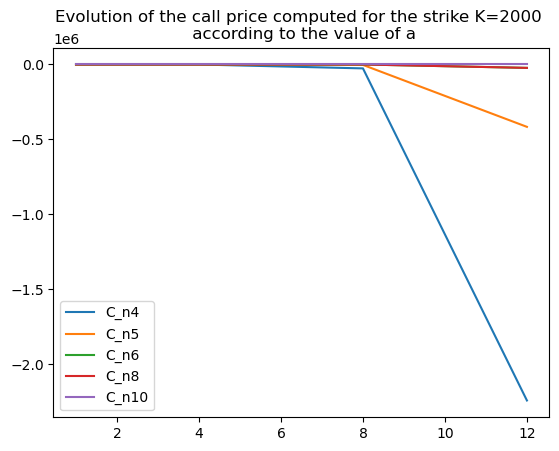

In [169]:
df_result_cos.drop(columns=['a']).plot()
plt.title(f'Evolution of the call price computed for the strike K={K} \n according to the value of a')
plt.show()

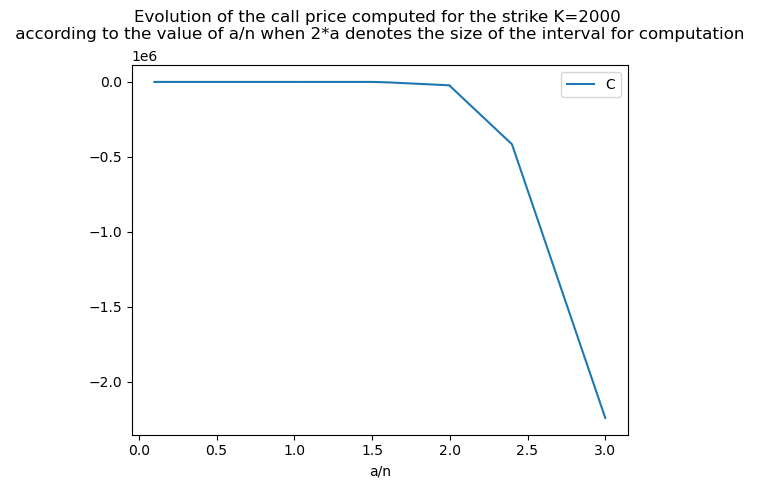

In [170]:
df_sensitivity.plot(x='a/n', y= 'C')
plt.title(f'Evolution of the call price computed for the strike K={K} \n according to the value of a/n when 2*a denotes the size of the interval for computation \n')
plt.show()

In [171]:
df_result_cos

,a,C_n4,C_n5,C_n6,C_n8,C_n10
1,1,9.524677e+01,95.246692,95.246692,95.246692,95.246692
4,4,-1.255621e+01,94.976632,95.247508,95.247508,95.246692
8,8,-2.600411e+04,-2792.860568,94.903750,94.903750,95.246692
12,12,-2.239888e+06,-415722.138656,-22626.099874,-22626.099874,95.246692


### Observations : 

We can see the call price computed depends on the values of the interval [-a,a]. The greater is a the greater we need to set the parameter n for the computation to be correct.

Indeed as can be seen in the first plot, when a is higher than 8, the call price computed deviates signigficantly. We can even say computation is instable for large values of a. 

More precisely, we can see in the last plot the correctness of the value of the call price depends on a/n which refers to the granularity we have for the computation on the [-a,a] interval. After 1.5, the value deviates significantly from the correct one.

# 4. Observations on the 3 methods:

When we consider the time of computation of the three methods, we observe FrFFT is in general almost 10 times faster than FFT. FrFFT is generaly performing between 0.004s and 0.02s. For the Fourier cosine method, it varies significantly between 0.004s to 5s depending on the interval [a,b] size and the n chosen. The smaller they are the faster is the algorithm. We also noticed before the computation time is attributable to the choice of using an approxiamtion of phi here. 

Moreover, we can see FrFFT perfoms well with N smaller than the ones used for the FFT which is one of the common advantage of FrFFT.

Then, when we look at the accuracy of the pricing we can see first it depends on the parameters chosen for each algorithms. Indeed, for instance too high lambda values for the Fourrier-cosine method or too small (0.4 for example) value of alpha for both FrFFT and FFT lead to inaccurate pricing. The sensitivity of the accuracy respect to these parameters varies between methods. 

In the case, it seems the FrFFT method provides a good balance between accuarcy and speed of computation but does not provide a good robustness with respect to the choice of its parameters compare to the two other methods. (It has the best 'best case' scenario)

The more robust method seems here to be FFT has it less sensitive with respect to the algorithm parameters. It is actually the FFT method  which is commonly used to price European options in which the underlying asset follows a log-normal distribution.